<a href="https://colab.research.google.com/github/wdon021/From_Colab/blob/master/Embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [3]:
!pip install fastai

In [0]:
from fastai.tabular import *
from sklearn import model_selection as ms
from sklearn.utils import resample

In [0]:
PATH = "/content/gdrive/My Drive/Fastai/"

In [0]:
import pandas as pd

In [0]:
h1b_raw = pd.read_csv(f'{PATH}H-1B_Disclosure_RAW_Data_FY18.csv', delimiter=',', engine='python')

In [0]:
h1b_1 = h1b_raw.drop(['CASE_NUMBER', 'CASE_SUBMITTED', 'DECISION_DATE', 'EMPLOYMENT_START_DATE', 'EMPLOYMENT_END_DATE'], axis=1)

In [0]:
procs = [FillMissing, Categorify, Normalize]

In [0]:
cat_vars = ['VISA_CLASS', 'EMPLOYER_NAME', 'EMPLOYER_BUSINESS_DBA',
       'EMPLOYER_ADDRESS', 'EMPLOYER_CITY', 'EMPLOYER_STATE',
       'EMPLOYER_POSTAL_CODE', 'EMPLOYER_COUNTRY', 'EMPLOYER_PROVINCE',
       'EMPLOYER_PHONE', 'EMPLOYER_PHONE_EXT', 'AGENT_REPRESENTING_EMPLOYER',
       'AGENT_ATTORNEY_NAME', 'AGENT_ATTORNEY_CITY', 'AGENT_ATTORNEY_STATE',
       'JOB_TITLE', 'SOC_CODE', 'SOC_NAME', 'NAICS_CODE', 
       'NEW_EMPLOYMENT', 'CONTINUED_EMPLOYMENT', 'CHANGE_PREVIOUS_EMPLOYMENT',
       'NEW_CONCURRENT_EMP', 'CHANGE_EMPLOYER', 'AMENDED_PETITION',
       'FULL_TIME_POSITION', 'PREVAILING_WAGE', 'PW_UNIT_OF_PAY',
       'PW_WAGE_LEVEL', 'PW_SOURCE', 'PW_SOURCE_YEAR', 'PW_SOURCE_OTHER',
       'WAGE_RATE_OF_PAY_FROM', 'WAGE_RATE_OF_PAY_TO', 'WAGE_UNIT_OF_PAY',
       'H1B_DEPENDENT', 'WILLFUL_VIOLATOR', 'SUPPORT_H1B', 'LABOR_CON_AGREE',
       'PUBLIC_DISCLOSURE_LOCATION', 'WORKSITE_CITY', 'WORKSITE_COUNTY',
       'WORKSITE_STATE', 'WORKSITE_POSTAL_CODE', 'ORIGINAL_CERT_DATE']
cont_vars = ['TOTAL_WORKERS']

In [0]:
for col in cat_vars:
    h1b_1[col] = h1b_1[col].astype('category')

In [0]:
emb = {'EMPLOYER_NAME':50, 'EMPLOYER_BUSINESS_DBA':50, 'EMPLOYER_ADDRESS':50, 'EMPLOYER_CITY':50, 'EMPLOYER_STATE':50, 'EMPLOYER_POSTAL_CODE':50, 'EMPLOYER_PHONE':50, 'AGENT_ATTORNEY_NAME':50, 'AGENT_ATTORNEY_CITY':50, 
       'JOB_TITLE':50, 'PREVAILING_WAGE':50,
       'WORKSITE_CITY':50,'PW_SOURCE_OTHER':50,
       'WAGE_RATE_OF_PAY_FROM':50, 'WAGE_RATE_OF_PAY_TO':50, 'WORKSITE_POSTAL_CODE':50, 'NAICS_CODE':50, 'WORKSITE_COUNTY':50}

In [0]:
h1b_1.drop(h1b_1.index[h1b_1['CASE_STATUS'] == 'CERTIFIED-WITHDRAWN'], inplace = True)
h1b_1.drop(h1b_1.index[h1b_1['CASE_STATUS'] == 'WITHDRAWN'], inplace = True)

In [16]:
h1b_1.CASE_STATUS.value_counts()

CERTIFIED    579449
DENIED         8627
Name: CASE_STATUS, dtype: int64

In [0]:
y = h1b_1.CASE_STATUS
X = h1b_1.drop('CASE_STATUS', axis=1)

In [18]:
X_train, X_valid, y_train, y_valid = ms.train_test_split(X, y, test_size=0.3, random_state=27)
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((411653, 46), (411653,), (176423, 46), (176423,))

In [0]:
dep_var = 'CASE_STATUS'
df = h1b_1[cat_vars+cont_vars+[dep_var]].copy()

In [0]:
valid_idx = range(41395)

In [0]:
data = (TabularList.from_df(df, path=PATH, cat_names=cat_vars, cont_names=cont_vars, procs=procs).split_by_idx(valid_idx).label_from_df(cols=dep_var).add_test(TabularList.from_df(X_valid, path=PATH, cat_names=cat_vars, cont_names=cont_vars)).databunch())

In [0]:
learn = tabular_learner(data, layers=[1000, 500], ps=[ 0.3, 0.1], emb_szs=emb, emb_drop=0.05, metrics=accuracy)

In [23]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(5, 4)
    (1): Embedding(70565, 50)
    (2): Embedding(11337, 50)
    (3): Embedding(63450, 50)
    (4): Embedding(5010, 50)
    (5): Embedding(56, 50)
    (6): Embedding(10783, 50)
    (7): Embedding(6, 4)
    (8): Embedding(348, 42)
    (9): Embedding(70109, 50)
    (10): Embedding(1115, 81)
    (11): Embedding(3, 3)
    (12): Embedding(6862, 50)
    (13): Embedding(1044, 50)
    (14): Embedding(56, 15)
    (15): Embedding(105857, 50)
    (16): Embedding(758, 66)
    (17): Embedding(927, 73)
    (18): Embedding(2041, 50)
    (19): Embedding(49, 14)
    (20): Embedding(25, 10)
    (21): Embedding(27, 10)
    (22): Embedding(11, 6)
    (23): Embedding(28, 10)
    (24): Embedding(22, 9)
    (25): Embedding(3, 3)
    (26): Embedding(27037, 50)
    (27): Embedding(6, 4)
    (28): Embedding(5, 4)
    (29): Embedding(6, 4)
    (30): Embedding(20, 9)
    (31): Embedding(3289, 50)
    (32): Embedding(55787, 50)
    (33): Embedding(16777

In [0]:
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [0]:
learn.model = learn.model.cuda()

In [25]:
learn.fit_one_cycle(5, 2e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.020608,0.728997,0.855441,04:24
1,0.018977,0.665610,0.864718,04:27
2,0.024680,0.639869,0.868269,04:26
3,0.023707,0.627791,0.869912,04:26
4,0.013640,0.636111,0.867955,04:26


In [27]:
learn.lr_find(start_lr=0.00001, end_lr=0.9, num_it=10000)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


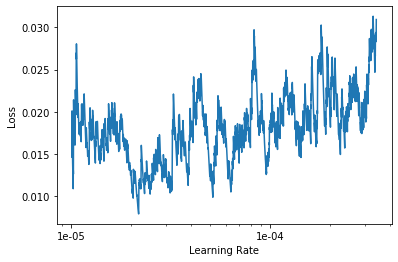

In [28]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(3, 2e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.017499,0.659789,0.864138,04:24


In [0]:
learn.save(f'{PATH}ForEmb2')

In [0]:
learn.save(f'{PATH}ForEmb')

In [0]:
learn.load(f'{PATH}ForEmb')

Learner(data=TabularDataBunch;

Train: LabelList (612965 items)
x: TabularList
VISA_CLASS H-1B; EMPLOYER_NAME IBM CORPORATION; EMPLOYER_BUSINESS_DBA #na#; EMPLOYER_ADDRESS 3039 CORNWALLIS RD; EMPLOYER_CITY DURHAM; EMPLOYER_STATE NC; EMPLOYER_POSTAL_CODE 27709; EMPLOYER_COUNTRY UNITED STATES OF AMERICA; EMPLOYER_PROVINCE #na#; EMPLOYER_PHONE 9192545595; EMPLOYER_PHONE_EXT #na#; AGENT_REPRESENTING_EMPLOYER N; AGENT_ATTORNEY_NAME ,; AGENT_ATTORNEY_CITY #na#; AGENT_ATTORNEY_STATE #na#; JOB_TITLE CLIENT TECHNICAL SPECIALIST; SOC_CODE 15-1132; SOC_NAME SOFTWARE DEVELOPERS, APPLICATIONS; NAICS_CODE 54151.0; NEW_EMPLOYMENT 0; CONTINUED_EMPLOYMENT 1; CHANGE_PREVIOUS_EMPLOYMENT 0; NEW_CONCURRENT_EMP 0; CHANGE_EMPLOYER 0; AMENDED_PETITION 0; FULL_TIME_POSITION Y; PREVAILING_WAGE 120,578.00; PW_UNIT_OF_PAY Year; PW_WAGE_LEVEL Level IV; PW_SOURCE OES; PW_SOURCE_YEAR 2017.0; PW_SOURCE_OTHER OFLC ONLINE DATACENTER; WAGE_RATE_OF_PAY_FROM 87,881.00; WAGE_RATE_OF_PAY_TO 180,533.00; WAGE_UNIT_OF_PAY Year

In [0]:
embs = list()

In [0]:
for param in learn.model.embeds.parameters():
  embs.append(param)

In [1]:
embs[1]

NameError: ignored

In [0]:
# self.classes = ds.classes = OrderedDict({n:np.concatenate([['#na#'],c.cat.categories.values])
embedding_names = ['UNKNOWN'] + list(h1b_1['EMPLOYER_NAME'].cat.categories)

In [0]:
embData = pd.DataFrame(embedding_names)

In [0]:
emb_data = embs[1]; type(emb_data)

torch.nn.parameter.Parameter

In [0]:
emb_data_array = emb_data.cpu().detach().numpy()

In [0]:
emb_data_array.shape

(70565, 50)

In [0]:
emb_data2 = pd.DataFrame(emb_data_array, index=embedding_names)

In [0]:
df_subset = emb_data2.copy()

In [0]:
import sklearn

In [0]:
sklearn.__version__

'0.21.3'

In [0]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
# dont know if I need transform

In [0]:
# stscaler = StandardScaler().fit(df_subset)

In [0]:
# df = stscaler.transform(df_subset)

In [0]:
from sklearn.cluster import OPTICS

In [0]:
!pip install hdbscan

     |████████████████████████████████| 4.9MB 2.7MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.23-cp36-cp36m-linux_x86_64.whl size=2332182 sha256=cf6314a8de27f4e14f3f92a5ee9e66eced7ca20ed1352c8a202513b56f0ca7c0
  Stored in directory: /root/.cache/pip/wheels/1e/2a/69/0cdd5414624312666718f7526b0ab39cad65cea1c1b3892768
Successfully built hdbscan


In [0]:
import hdbscan

In [0]:
clusterer = hdbscan.HDBSCAN(metric='manhattan')

In [0]:
clusterer.fit(df_subset)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_method='eom',
        core_dist_n_jobs=4, gen_min_span_tree=False, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='manhattan', min_cluster_size=5, min_samples=None, p=None,
        prediction_data=False)

In [0]:
clusterer.labels_.max()

1

In [0]:
clustering = OPTICS(eps=50, min_samples=15).fit(emb_data_array)

KeyboardInterrupt: ignored

In [0]:
dbsc = DBSCAN(eps=50, min_samples=15,algorithm='ball_tree').fit(emb_data_array)

In [0]:
labels = dbsc.labels_

In [0]:
sum(labels>0)

0

In [0]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline

In [0]:
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
RS = 123

In [0]:
from sklearn.manifold import TSNE
time_start = time.time()
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300, metric='euclidean', random_state=RS)
fashion_tsne = tsne.fit_transform(emb_data2)

print('t-SNE done! Time elapsed:{} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed:2008.8356301784515 seconds


In [0]:
type(fashion_tsne)

numpy.ndarray

In [0]:
df_subset['tsne-2d-one'] = fashion_tsne[:,0]
df_subset['tsne-2d-two'] = fashion_tsne[:,1]

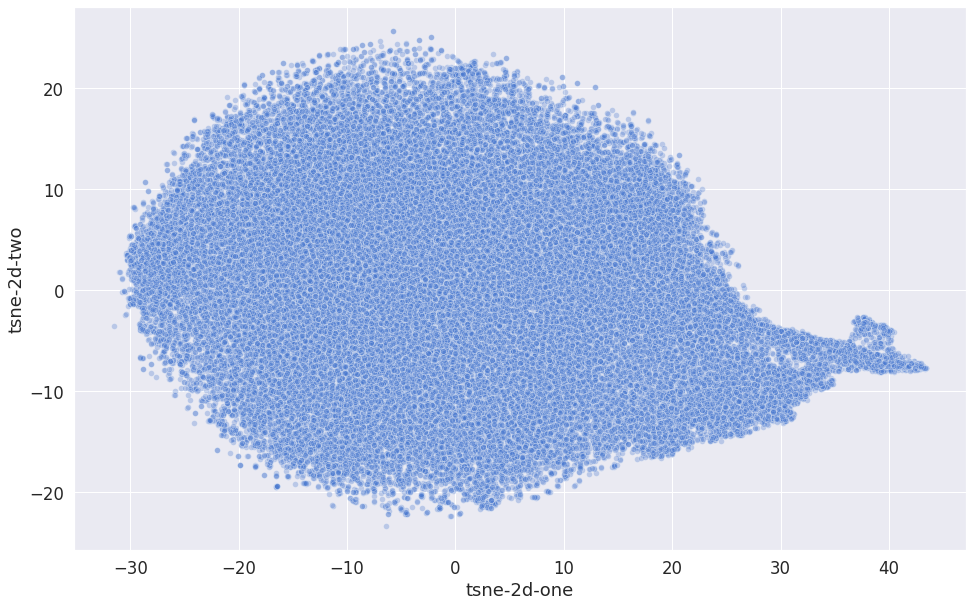

In [0]:
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x='tsne-2d-one', y='tsne-2d-two', #hue="y"
    palette = sns.color_palette('hls', 10),
    data=df_subset,
    alpha=0.3
)

In [0]:
unique_row= list(source1.index.values)

In [0]:
unique_row

In [0]:
def tokenize_corpus(corpus):
  tokens = [x.split() for x in corpus]
  return tokens

In [0]:
tokenized_corpus = tokenize_corpus(unique_row)

In [0]:
tokenized_corpus

[['OFLC', 'ONLINE', 'DATA', 'CENTER'],
 ['RADFORD', 'GLOBAL', 'TECHNOLOGY', 'SURVEY'],
 ['ONLINE', 'WAGE', 'LIBRARY'],
 ['OFLC', '(ONLINE', 'DATA', 'CENTER)'],
 ['OFLC', 'ONLINE', 'DATA', "CENTER'"],
 ['US', 'MBD', 'MERCER', 'BENCHMARK', 'DATABASE', 'IT', 'SURVEY'],
 ['DIETRICH', 'FALL', '2017', 'ENGINEERING', 'SALARY', 'SURVEY'],
 ['RADFORD', 'GLOBAL', 'TECHNOLOGY', 'SURVEY', 'CUSTOM', 'REPORT'],
 ['WILLIS',
  'TOWERS',
  'WATSON:',
  'PROFESSIONAL',
  '(TECHNICAL',
  'AND',
  'OPERATIONS)',
  'COMPENSATION',
  'SUR'],
 ['COLLECTIVE', 'BARGAINING', 'AGREEMENT'],
 ['AAMC', 'SURVEY', 'OF', 'RESIDENT/FELLOW', 'STIPENDS', 'AND', 'BENEFITS'],
 ['OFLC', 'ONLINE', 'DATACENTER'],
 ['TOWERS',
  'WATSON',
  'PROFESSIONAL',
  '(INFORMATION',
  'TECHNOLOGY)',
  'COMPENSATION',
  'SURVEY'],
 ['MERCER', 'BENCHMARK', 'DATABASE', 'SURVEY'],
 ['TOWERS',
  'WATSON',
  'PROFESSIONAL',
  '(TECHNICAL',
  'AND',
  'OPERATIONS)',
  'COMPENSATION',
  'SURVEY'],
 ['TOWERS',
  'WATSON:',
  '2017',
  'PROFESSIO

In [0]:
vocabulary = []

In [0]:
for sentence in tokenized_corpus:
  for token in sentence:
    if token not in vocabulary:
      vocabulary.append(token)

In [0]:
word2idx = {w:idx for (idx,w) in enumerate(vocabulary)}
idx2word 

['OFLC',
 'ONLINE',
 'DATA',
 'CENTER',
 'RADFORD',
 'GLOBAL',
 'TECHNOLOGY',
 'SURVEY',
 'WAGE',
 'LIBRARY',
 '(ONLINE',
 'CENTER)',
 "CENTER'",
 'US',
 'MBD',
 'MERCER',
 'BENCHMARK',
 'DATABASE',
 'IT',
 'DIETRICH',
 'FALL',
 '2017',
 'ENGINEERING',
 'SALARY',
 'CUSTOM',
 'REPORT',
 'WILLIS',
 'TOWERS',
 'WATSON:',
 'PROFESSIONAL',
 '(TECHNICAL',
 'AND',
 'OPERATIONS)',
 'COMPENSATION',
 'SUR',
 'COLLECTIVE',
 'BARGAINING',
 'AGREEMENT',
 'AAMC',
 'OF',
 'RESIDENT/FELLOW',
 'STIPENDS',
 'BENEFITS',
 'DATACENTER',
 'WATSON',
 '(INFORMATION',
 'TECHNOLOGY)',
 '(ADMINISTRATIVE',
 'SALES)',
 'SURV',
 'ACWIA',
 'WWW.FLCDATACENTER.COM',
 '&',
 'PROF.',
 'COMP.',
 'INFORMATION',
 'AIA',
 'CSR',
 'GENERAL',
 'INDUS',
 "PROF'L",
 '(TECH',
 'COMP',
 'RESIDENT',
 'FELLOW',
 'PREVAILING',
 'DETERMINED',
 'BY',
 'CBA',
 'SPRING',
 '2018',
 'CENTER-ACWIA',
 'FLC',
 'SURVE',
 'SALES',
 'COMPSOURCE',
 'COMPENSA',
 'WILLISTOWERS',
 'INDUSTRY',
 'OPER',
 'THE',
 'GROUP:',
 'CENTRE',
 '-',
 'SUPERVISO